# Topic Trends - Pandemics

This code was created from Martha and Sean's emerging topic code. 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm
from scipy import stats

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

from brokenaxes import brokenaxes

ModuleNotFoundError: No module named 'brokenaxes'

### Data Ingestion

In [2]:
# upload the data
df = pd.read_csv('/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/abstracts_classification_big_data.csv')
df.reset_index(inplace=True, drop = True)

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (15,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.shape

(39997, 42)

In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,index,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT,Prediction_RF,Prediction_NN,score,Big_data
0,14,14,90013,This multidisciplinary project draws upon soci...,career; Collaborations; Communities; Complex; ...,CDI-TYPE II: WHAT DRIVES THE DYNAMIC CREATION ...,NSF,NSF,NaN,0835614,9/15/2008,8/31/2012,"MCFARLAND, DANIEL","JURAFSKY, DANIEL; MANNING, CHRISTOPHER; POWELL...",14.0,009214214,STANFORD UNIVERSITY,STANFORD,CA,94305-6203,UNITED STATES,NaN,NaN,47.076,2008,1186174.0,NaN,1,1,1186174.0,1,multidisciplinary project draw sociology compu...,14,NaN,NaN,Big-data,Non Big-data,Non Big-data,Big-data,Big-data,3,1
1,21,21,89990,Pruden 0547342 This research opens a new par...,Address; Anthrax disease; anthropogenesis; Ant...,CAREER: ANTIBIOTIC RESISTANCE GENES (ARG) AS E...,NSF,NSF,NaN,0852942,9/1/2008,1/31/2011,"PRUDEN, AMY J",NaN,9.0,003137015,VIRGINIA POLYTECHNIC INSTITUTE AND STATE UNIVE...,BLACKSBURG,VA,24060-0000,UNITED STATES,NaN,NaN,47.041,2008,197729.0,NaN,1,1,197729.0,1,pruden research open new paradigm view biomole...,21,NaN,NaN,Big-data,Non Big-data,Non Big-data,Big-data,Big-data,3,1
2,28,28,89972,Eye tracking has become a widespread tool thro...,Affect; Attention; Attention Deficit Disorder;...,CDI-TYPE I: UNDERSTANDING REGULATION OF VISUAL...,NSF,NSF,NaN,0835767,10/1/2008,3/31/2012,"SCASSELLATI, BRIAN M","CHAWARSKA, KATARZYNA",3.0,043207562,YALE UNIVERSITY,NEW HAVEN,CT,06520-8337,UNITED STATES,NaN,NaN,47.075,2008,700000.0,NaN,1,1,700000.0,1,eye tracking widespread tool cognitive science...,28,NaN,NaN,Big-data,Non Big-data,Non Big-data,Big-data,Big-data,3,1
3,39,39,89969,"The proposed workshop, to be held at the Banff...",Canada; Cognition; Cognitive; Collaborations; ...,PROBABILISTIC MODELS OF LEARNING AND COGNITIVE...,NSF,NSF,NaN,0838595,10/1/2008,9/30/2009,"GRIFFITHS, THOMAS L",NaN,9.0,124726725,UNIVERSITY OF CALIFORNIA BERKELEY,BERKELEY,CA,94704-5940,UNITED STATES,NaN,NaN,47.076,2008,31309.0,NaN,1,1,31309.0,1,propose workshop hold_banff international rese...,39,NaN,NaN,Big-data,Non Big-data,Non Big-data,Big-data,Big-data,3,1
4,42,42,90050,Iron and Copper serve as key co-constituents f...,Address; aqueous; biological systems; Carbon; ...,COLLABORATIVE RESEARCH: A NANOSTRUCTURE SENSOR...,NSF,NSF,NaN,0826098,10/1/2008,9/30/2012,"WELLS, MARK L","TRIPP, CARL",2.0,186875787,UNIVERSITY OF MAINE ORONO,ORONO,ME,04469-5717,UNITED STATES,NaN,NaN,47.050,2008,969713.0,NaN,1,1,969713.0,1,iron copper serve key co constituent numerous ...,42,NaN,NaN,Big-data,Non Big-data,Big-data,Big-data,Non Big-data,3,1


In [5]:
# input needed for NMF (from Scikit-Learn) is one string per document (not a list of strings)

text = df["final_tokens"]

In [6]:
cb_pal = {"blue":'#377eb8', "orange":'#ff7f00', "green":'#4daf4a', "pink":'#f781bf', "brown":'#a65628', 
          "purple":'#984ea3', "gray":'#999999', "red":'#e41a1c', "yellow":'#dede00'}

### Functions needed for all models

In [59]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [60]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF

In [61]:
stop_wds = ['research', 'aim', 'project']

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False, stop_words=stop_wds)
tf_idf = tfidf_vectorizer.fit_transform(text)

In [110]:
# create model

num_topics = 20

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 27.026358604431152


In [111]:
print_topics(topic_term, tfidf_vectorizer, 10)


Topic 0:
('model', 2.8643249719210924)
('method', 2.5674831800844533)
('statistical', 2.1590133597832066)
('datum', 1.4222831907466396)
('develop', 1.0953707665193426)
('dimensional', 1.0655079474605036)
('inference', 0.9450181242507554)
('analysis', 0.7835168945537315)
('high', 0.7643627592316179)
('study', 0.748233713205333)

Topic 1:
('genetic', 2.3867550041850794)
('disease', 1.5166010763418734)
('variant', 1.2063295453982188)
('association', 0.9890690807131591)
('study', 0.6627054717769385)
('trait', 0.652135216680246)
('population', 0.6377503541911054)
('phenotype', 0.6016112419147377)
('rare', 0.5381682470022504)
('method', 0.5369080987391032)

Topic 2:
('core', 2.646495394767582)
('management', 0.9245635646654727)
('analysis', 0.7735124205114363)
('statistical', 0.7376694329291649)
('provide', 0.6330990677811298)
('data', 0.6300858098302777)
('investigator', 0.6280272501798851)
('support', 0.6242271270946215)
('center', 0.5986444417241654)
('datum', 0.5040149814063898)

Topic 

### Topic Trends

In [112]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["FY"] = df["FY"]

In [113]:
topic_frame

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,FY
0,0.006414,0.000000,0.000000,0.027051,0.009852,0.021026,0.036685,0.000000,0.010255,0.013172,0.000728,0.008750,0.005655,0.000000,0.000000,0.000000,0.017744,0.002279,0.000000,0.000000,2008
1,0.001690,0.000000,0.001475,0.041554,0.000000,0.026103,0.000000,0.001449,0.000000,0.011717,0.000000,0.022693,0.008185,0.000000,0.004544,0.000000,0.000000,0.000000,0.002203,0.010499,2008
2,0.016710,0.006562,0.000784,0.002749,0.000000,0.023179,0.000000,0.001865,0.000000,0.000997,0.016740,0.020109,0.000000,0.000000,0.001000,0.001657,0.012160,0.000000,0.000000,0.001490,2008
3,0.024608,0.000000,0.000000,0.024413,0.000000,0.000000,0.000000,0.000000,0.000000,0.006877,0.000000,0.064077,0.000578,0.000000,0.000000,0.000000,0.025655,0.001284,0.000000,0.000000,2008
4,0.001943,0.001259,0.000000,0.016810,0.000000,0.006274,0.000000,0.000379,0.003267,0.023903,0.002750,0.000000,0.004498,0.000000,0.001509,0.001331,0.007733,0.002803,0.016630,0.010082,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39992,0.000000,0.002752,0.004446,0.008387,0.053091,0.000000,0.001174,0.000000,0.016732,0.000000,0.000000,0.000000,0.028889,0.000000,0.000000,0.000000,0.000000,0.000000,0.001229,0.006608,2020
39993,0.018243,0.000000,0.000000,0.000000,0.000000,0.028818,0.011925,0.002412,0.016518,0.020089,0.000000,0.019866,0.000000,0.000000,0.000000,0.000000,0.000700,0.000000,0.000000,0.000107,2020
39994,0.000000,0.000000,0.003968,0.012033,0.004964,0.000678,0.005157,0.000147,0.052248,0.046698,0.000000,0.000000,0.000000,0.001273,0.002140,0.000000,0.000000,0.000000,0.000000,0.000000,2020
39995,0.000000,0.000000,0.003968,0.012033,0.004964,0.000678,0.005157,0.000147,0.052248,0.046698,0.000000,0.000000,0.000000,0.001273,0.002140,0.000000,0.000000,0.000000,0.000000,0.000000,2020


#### compute count of projects with weight > 0 for each topic

In [114]:
topic_proj_count = topic_frame.copy()

In [115]:
topic_proj_count.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,FY
0,0.006414,0.000000,0.000000,0.027051,0.009852,0.021026,0.036685,0.000000,0.010255,0.013172,0.000728,0.008750,0.005655,0.0,0.000000,0.000000,0.017744,0.002279,0.000000,0.000000,2008
1,0.001690,0.000000,0.001475,0.041554,0.000000,0.026103,0.000000,0.001449,0.000000,0.011717,0.000000,0.022693,0.008185,0.0,0.004544,0.000000,0.000000,0.000000,0.002203,0.010499,2008
2,0.016710,0.006562,0.000784,0.002749,0.000000,0.023179,0.000000,0.001865,0.000000,0.000997,0.016740,0.020109,0.000000,0.0,0.001000,0.001657,0.012160,0.000000,0.000000,0.001490,2008
3,0.024608,0.000000,0.000000,0.024413,0.000000,0.000000,0.000000,0.000000,0.000000,0.006877,0.000000,0.064077,0.000578,0.0,0.000000,0.000000,0.025655,0.001284,0.000000,0.000000,2008
4,0.001943,0.001259,0.000000,0.016810,0.000000,0.006274,0.000000,0.000379,0.003267,0.023903,0.002750,0.000000,0.004498,0.0,0.001509,0.001331,0.007733,0.002803,0.016630,0.010082,2008


In [116]:
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["FY"] = topic_proj_count["FY"]

In [117]:
topic_count_bool

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,FY
0,True,False,False,True,True,True,True,False,True,True,True,True,True,False,False,False,True,True,False,False,2008
1,True,False,True,True,False,True,False,True,False,True,False,True,True,False,True,False,False,False,True,True,2008
2,True,True,True,True,False,True,False,True,False,True,True,True,False,False,True,True,True,False,False,True,2008
3,True,False,False,True,False,False,False,False,False,True,False,True,True,False,False,False,True,True,False,False,2008
4,True,True,False,True,False,True,False,True,True,True,True,False,True,False,True,True,True,True,True,True,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39992,False,True,True,True,True,False,True,False,True,False,False,False,True,False,False,False,False,False,True,True,2020
39993,True,False,False,False,False,True,True,True,True,True,False,True,False,False,False,False,True,False,False,True,2020
39994,False,False,True,True,True,True,True,True,True,True,False,False,False,True,True,False,False,False,False,False,2020
39995,False,False,True,True,True,True,True,True,True,True,False,False,False,True,True,False,False,False,False,False,2020


In [118]:
topic_count_bool.sum(axis=1).median()

2026.0

In [119]:
# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("FY").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "FY")  # pretty sure this is unnecessary
topic_counts["FY"] = topic_counts["FY"].astype(int)

In [120]:
topic_counts

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,2008,1340,987,1214,1168,1271,1051,932,878,1482,1128,989,971,1349,767,968,1038,1013,822,943,1288
1,2009,1546,1130,1309,1401,1482,1242,1084,1015,1686,1362,1114,1141,1553,844,1074,1083,1150,975,1120,1529
2,2010,1466,1100,1269,1357,1428,1365,1058,1042,1696,1313,1122,1108,1479,887,1067,1084,1166,981,1065,1452
3,2011,1390,992,1150,1322,1227,1237,961,918,1478,1196,980,1014,1380,742,977,951,1008,846,1011,1297
4,2012,1496,1119,1221,1416,1398,1348,1081,976,1646,1260,1096,1095,1486,842,1061,1014,1129,900,1114,1419
5,2013,1638,1187,1373,1580,1558,1398,1242,1063,1853,1406,1180,1223,1551,904,1208,1051,1198,997,1241,1519
6,2014,1709,1314,1444,1622,1655,1433,1271,1202,1978,1482,1253,1360,1605,1070,1315,1135,1356,953,1291,1613
7,2015,1965,1449,1610,1782,1852,1612,1492,1349,2291,1623,1394,1538,1787,1162,1456,1241,1465,1066,1499,1817
8,2016,2049,1547,1751,2011,2021,1820,1625,1560,2546,1813,1563,1731,1875,1299,1558,1290,1642,1166,1620,1939
9,2017,2048,1558,1707,1976,1967,1746,1701,1591,2499,1715,1579,1825,1820,1359,1596,1368,1625,1133,1597,1918


In [121]:
# note if filtering data set to specific years - set here

year_st = 2008
year_end = 2020

In [122]:
topic_counts_filt = topic_counts[topic_counts["FY"] >= year_st] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["FY"] <= year_end]

In [123]:
topic_counts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,2008,1340,987,1214,1168,1271,1051,932,878,1482,1128,989,971,1349,767,968,1038,1013,822,943,1288
1,2009,1546,1130,1309,1401,1482,1242,1084,1015,1686,1362,1114,1141,1553,844,1074,1083,1150,975,1120,1529
2,2010,1466,1100,1269,1357,1428,1365,1058,1042,1696,1313,1122,1108,1479,887,1067,1084,1166,981,1065,1452
3,2011,1390,992,1150,1322,1227,1237,961,918,1478,1196,980,1014,1380,742,977,951,1008,846,1011,1297
4,2012,1496,1119,1221,1416,1398,1348,1081,976,1646,1260,1096,1095,1486,842,1061,1014,1129,900,1114,1419
5,2013,1638,1187,1373,1580,1558,1398,1242,1063,1853,1406,1180,1223,1551,904,1208,1051,1198,997,1241,1519
6,2014,1709,1314,1444,1622,1655,1433,1271,1202,1978,1482,1253,1360,1605,1070,1315,1135,1356,953,1291,1613
7,2015,1965,1449,1610,1782,1852,1612,1492,1349,2291,1623,1394,1538,1787,1162,1456,1241,1465,1066,1499,1817
8,2016,2049,1547,1751,2011,2021,1820,1625,1560,2546,1813,1563,1731,1875,1299,1558,1290,1642,1166,1620,1939
9,2017,2048,1558,1707,1976,1967,1746,1701,1591,2499,1715,1579,1825,1820,1359,1596,1368,1625,1133,1597,1918


In [124]:
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0     24854
Topic 1     18263
Topic 2     20571
Topic 3     24023
Topic 4     23692
Topic 5     21718
Topic 6     19154
Topic 7     17585
Topic 8     28747
Topic 9     21798
Topic 10    18499
Topic 11    21083
Topic 12    23258
Topic 13    14891
Topic 14    18115
Topic 15    16318
Topic 16    19021
Topic 17    14935
Topic 18    19032
Topic 19    23923
dtype: int64

#### calculate mean topic weight by year and standard errors on means

In [125]:
topic_frame_se = topic_frame.groupby("FY").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "FY")
topic_frame_se["FY"] = topic_frame_se["FY"].astype(int)

topic_wts_se_filt = topic_frame_se[topic_frame_se["FY"] >= year_st] 
topic_wts_se_filt = topic_wts_se_filt[topic_wts_se_filt["FY"] <= year_end]

In [126]:
topic_frame = topic_frame.groupby("FY").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "FY")
topic_frame["FY"] = topic_frame["FY"].astype(int)

In [127]:
topic_frame

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,2008,0.006583,0.006196,0.010468,0.008305,0.008030,0.006431,0.006351,0.003309,0.010734,0.006356,0.005923,0.004383,0.007545,0.004226,0.006278,0.008027,0.007925,0.002117,0.005550,0.007661
1,2009,0.006602,0.005754,0.008469,0.008264,0.008795,0.006896,0.006389,0.003892,0.010454,0.007193,0.005879,0.004656,0.008101,0.003652,0.006723,0.007140,0.007424,0.001952,0.005596,0.008863
2,2010,0.006388,0.006503,0.008229,0.008831,0.008129,0.008101,0.006630,0.004640,0.010532,0.007468,0.005801,0.004599,0.007475,0.003625,0.006459,0.006492,0.007448,0.002046,0.005019,0.008220
3,2011,0.006663,0.006088,0.008589,0.009217,0.007568,0.008253,0.006695,0.003978,0.010215,0.007391,0.005666,0.004778,0.007972,0.003731,0.006868,0.006803,0.007357,0.001903,0.005285,0.008493
4,2012,0.006523,0.006531,0.008313,0.009024,0.008600,0.007809,0.006568,0.003789,0.010509,0.006843,0.005696,0.005255,0.007907,0.003789,0.006859,0.006398,0.007451,0.001845,0.006244,0.008404
5,2013,0.006168,0.006359,0.008852,0.009569,0.008334,0.006955,0.006641,0.004098,0.011483,0.007315,0.005234,0.005518,0.007189,0.004138,0.006930,0.005821,0.006709,0.001965,0.006094,0.008007
6,2014,0.006203,0.006551,0.009422,0.009056,0.008227,0.006726,0.006839,0.004343,0.012105,0.006510,0.005538,0.005917,0.006856,0.004677,0.007119,0.005843,0.007724,0.001482,0.006233,0.007987
7,2015,0.006302,0.005898,0.009385,0.008642,0.008398,0.006950,0.006537,0.004206,0.012388,0.006592,0.005330,0.006318,0.007132,0.004160,0.006669,0.005006,0.007402,0.001943,0.006575,0.008700
8,2016,0.005679,0.005855,0.008846,0.009427,0.008269,0.007299,0.005933,0.004608,0.012389,0.006494,0.006097,0.006488,0.006719,0.004489,0.006604,0.004672,0.007357,0.002169,0.006358,0.007729
9,2017,0.005618,0.005625,0.008958,0.009472,0.008161,0.007113,0.006982,0.004852,0.012187,0.005017,0.006193,0.007711,0.006596,0.004624,0.006192,0.004533,0.007348,0.002053,0.006637,0.008059


In [128]:
# filter topic_frame for years 

topic_wts_filt = topic_frame[topic_frame["FY"] >= year_st] 
topic_wts_filt = topic_wts_filt[topic_wts_filt["FY"] <= year_end] 

In [129]:
topic_wts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,2008,0.006583,0.006196,0.010468,0.008305,0.008030,0.006431,0.006351,0.003309,0.010734,0.006356,0.005923,0.004383,0.007545,0.004226,0.006278,0.008027,0.007925,0.002117,0.005550,0.007661
1,2009,0.006602,0.005754,0.008469,0.008264,0.008795,0.006896,0.006389,0.003892,0.010454,0.007193,0.005879,0.004656,0.008101,0.003652,0.006723,0.007140,0.007424,0.001952,0.005596,0.008863
2,2010,0.006388,0.006503,0.008229,0.008831,0.008129,0.008101,0.006630,0.004640,0.010532,0.007468,0.005801,0.004599,0.007475,0.003625,0.006459,0.006492,0.007448,0.002046,0.005019,0.008220
3,2011,0.006663,0.006088,0.008589,0.009217,0.007568,0.008253,0.006695,0.003978,0.010215,0.007391,0.005666,0.004778,0.007972,0.003731,0.006868,0.006803,0.007357,0.001903,0.005285,0.008493
4,2012,0.006523,0.006531,0.008313,0.009024,0.008600,0.007809,0.006568,0.003789,0.010509,0.006843,0.005696,0.005255,0.007907,0.003789,0.006859,0.006398,0.007451,0.001845,0.006244,0.008404
5,2013,0.006168,0.006359,0.008852,0.009569,0.008334,0.006955,0.006641,0.004098,0.011483,0.007315,0.005234,0.005518,0.007189,0.004138,0.006930,0.005821,0.006709,0.001965,0.006094,0.008007
6,2014,0.006203,0.006551,0.009422,0.009056,0.008227,0.006726,0.006839,0.004343,0.012105,0.006510,0.005538,0.005917,0.006856,0.004677,0.007119,0.005843,0.007724,0.001482,0.006233,0.007987
7,2015,0.006302,0.005898,0.009385,0.008642,0.008398,0.006950,0.006537,0.004206,0.012388,0.006592,0.005330,0.006318,0.007132,0.004160,0.006669,0.005006,0.007402,0.001943,0.006575,0.008700
8,2016,0.005679,0.005855,0.008846,0.009427,0.008269,0.007299,0.005933,0.004608,0.012389,0.006494,0.006097,0.006488,0.006719,0.004489,0.006604,0.004672,0.007357,0.002169,0.006358,0.007729
9,2017,0.005618,0.005625,0.008958,0.009472,0.008161,0.007113,0.006982,0.004852,0.012187,0.005017,0.006193,0.007711,0.006596,0.004624,0.006192,0.004533,0.007348,0.002053,0.006637,0.008059


In [130]:
topic_wts_se_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,2008,0.000216,0.000362,0.000487,0.000323,0.000282,0.000311,0.000358,0.000184,0.000286,0.000296,0.000339,0.000232,0.000284,0.000339,0.000344,0.000429,0.000362,0.000241,0.000305,0.000287
1,2009,0.000205,0.000323,0.000402,0.000286,0.000269,0.000300,0.000324,0.000215,0.000266,0.000300,0.000320,0.000226,0.000285,0.000264,0.000368,0.000388,0.000334,0.000168,0.000272,0.000288
2,2010,0.000203,0.000362,0.000392,0.000302,0.000259,0.000324,0.000346,0.000244,0.000262,0.000332,0.000324,0.000212,0.000272,0.000265,0.000357,0.000370,0.000326,0.000207,0.000256,0.000298
3,2011,0.000219,0.000359,0.000439,0.000313,0.000271,0.000349,0.000368,0.000226,0.000282,0.000337,0.000335,0.000219,0.000304,0.000294,0.000390,0.000411,0.000344,0.000216,0.000258,0.000310
4,2012,0.000209,0.000355,0.000416,0.000293,0.000288,0.000317,0.000329,0.000205,0.000280,0.000311,0.000319,0.000253,0.000288,0.000279,0.000364,0.000368,0.000324,0.000175,0.000314,0.000308
5,2013,0.000189,0.000330,0.000416,0.000301,0.000264,0.000282,0.000316,0.000212,0.000283,0.000307,0.000286,0.000241,0.000255,0.000294,0.000334,0.000332,0.000293,0.000169,0.000288,0.000278
6,2014,0.000183,0.000324,0.000426,0.000285,0.000249,0.000270,0.000324,0.000209,0.000282,0.000281,0.000291,0.000255,0.000243,0.000292,0.000327,0.000316,0.000364,0.000116,0.000290,0.000264
7,2015,0.000178,0.000277,0.000402,0.000270,0.000242,0.000258,0.000297,0.000191,0.000267,0.000268,0.000261,0.000254,0.000233,0.000253,0.000295,0.000267,0.000329,0.000196,0.000278,0.000273
8,2016,0.000159,0.000260,0.000370,0.000273,0.000228,0.000257,0.000256,0.000193,0.000250,0.000250,0.000281,0.000237,0.000225,0.000248,0.000274,0.000247,0.000309,0.000208,0.000252,0.000234
9,2017,0.000154,0.000250,0.000373,0.000276,0.000226,0.000250,0.000292,0.000196,0.000244,0.000201,0.000279,0.000272,0.000221,0.000255,0.000254,0.000236,0.000304,0.000202,0.000263,0.000251


In [131]:
# perform regressions, track slopes

topic_slopes = []
p_values = []

for i in range(1,num_topics+1):
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    #topic_slopes.append(linear_fit.coef_[0][0])
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt.iloc[:,i].values)
    topic_slopes.append(linear_fit.slope)
    p_values.append(linear_fit.pvalue)


In [132]:
topic_slopes[:num_topics]

[-0.000133642734684424,
 -0.00017149761222584286,
 -0.00017248052696098375,
 0.00015662363259236916,
 -6.0529164951974195e-05,
 6.225315080561911e-06,
 -6.17352393577887e-05,
 5.082043611692422e-05,
 4.2191334902595256e-05,
 -7.172831312307103e-05,
 -3.962488865927778e-05,
 0.0005304523868910022,
 -9.785804604534539e-05,
 -2.9642709961784544e-05,
 -0.00019623932187014134,
 -0.00038160773016256524,
 -0.00013195697066283797,
 0.00017749989852166277,
 8.331308075737946e-05,
 3.1723224594224636e-06]

In [133]:
p_values[:5]

[9.825677704834525e-06,
 0.0024177748378668993,
 0.01900789347655679,
 0.00037984855798321894,
 0.08658536524060943]

In [134]:
leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

In [135]:
leg[:5]

['model, method, statistical, datum, develop',
 'genetic, disease, variant, association, study',
 'core, management, analysis, statistical, provide',
 'student, science, program, training, education',
 'software, computing, performance, application, memory']

In [136]:
n_by_topic.values

array([24854, 18263, 20571, 24023, 23692, 21718, 19154, 17585, 28747,
       21798, 18499, 21083, 23258, 14891, 18115, 16318, 19021, 14935,
       19032, 23923])

In [137]:
# package up data 

reg_topics = pd.DataFrame()
reg_topics["Label"] = ''
reg_topics["n"] = n_by_topic.values
reg_topics["Slopex100"] = [slope*100 for slope in topic_slopes]
reg_topics["p-value"] = p_values
reg_topics["Topic Words"] = leg 

# sort by topic words
reg_topics = reg_topics.sort_values(by=["Topic Words"])

# add labels
for i in range(len(reg_topics)):
    reg_topics["Label"].iloc[i] = "p%d" % (i+1)

/home/yhu2bk/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [138]:
reg_topics

,Label,n,Slopex100,p-value,Topic Words
13,p1,14891,-0.002964,4.590895e-01,"cancer, genomic, tumor, breast, clinical"
9,p2,21798,-0.007173,1.313237e-01,"climate, change, water, specie, environmental"
2,p3,20571,-0.017248,1.900789e-02,"core, management, analysis, statistical, provide"
8,p4,28747,0.004219,5.389073e-01,"datum, data, big, analysis, set"
15,p5,16318,-0.038161,9.328173e-10,"gene, expression, cell, pathway, regulatory"
1,p6,18263,-0.017150,2.417775e-03,"genetic, disease, variant, association, study"
5,p7,21718,0.000623,8.975065e-01,"health, social, public, population, policy"
10,p8,18499,-0.003962,1.291576e-01,"image, brain, imaging, mri, analysis"
11,p9,21083,0.053045,2.555601e-06,"learning, learn, machine, deep, algorithm"
0,p10,24854,-0.013364,9.825678e-06,"model, method, statistical, datum, develop"


In [139]:
#reg_topics.to_csv("./csvs/pan_20topics.csv", index=False)

## Grid Plot

In [140]:
# sort topics by slope

def sort_list(x):
    return sorted(enumerate(x), key=lambda l: l[1], reverse=True)

In [141]:
sort_slopes = sort_list(topic_slopes)

sort_slopes[:num_topics] # sort_slopes now goes from 0 to 29

[(11, 0.0005304523868910022),
 (17, 0.00017749989852166277),
 (3, 0.00015662363259236916),
 (18, 8.331308075737946e-05),
 (7, 5.082043611692422e-05),
 (8, 4.2191334902595256e-05),
 (5, 6.225315080561911e-06),
 (19, 3.1723224594224636e-06),
 (13, -2.9642709961784544e-05),
 (10, -3.962488865927778e-05),
 (4, -6.0529164951974195e-05),
 (6, -6.17352393577887e-05),
 (9, -7.172831312307103e-05),
 (12, -9.785804604534539e-05),
 (16, -0.00013195697066283797),
 (0, -0.000133642734684424),
 (1, -0.00017149761222584286),
 (2, -0.00017248052696098375),
 (14, -0.00019623932187014134),
 (15, -0.00038160773016256524)]

In [142]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 0-29

# leg: indices 0-29

[11, 17, 3, 18, 7, 8, 5, 19, 13, 10, 4, 6, 9, 12, 16, 0, 1, 2, 14, 15]

In [143]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx-1] + ' \n' + title[idx:])
    

In [144]:
new_leg

['model, method, statistical \n datum, develop',
 'genetic, disease, variant \n association, study',
 'core, management, analysis \n statistical, provide',
 'student, science, program \n training, education',
 'software, computing, performance \n application, memory',
 'health, social, public \n population, policy',
 'network, social, node \n graph, dynamic',
 'patient, clinical, care \n treatment, medical',
 'datum, data, big \n analysis, set',
 'climate, change, water \n specie, environmental',
 'image, brain, imaging \n mri, analysis',
 'learning, learn, machine \n deep, algorithm',
 'problem, algorithm, theory \n graph, optimization',
 'cancer, genomic, tumor \n breast, clinical',
 'sequence, genome, genomic \n dna, sequencing',
 'gene, expression, cell \n pathway, regulatory',
 'protein, computational, proteomic \n biological, biology',
 'quantum, material, physics \n theory, information',
 'wireless, sensor, device \n mobile, spectrum',
 'system, energy, control \n power, design'

In [145]:
# add topic labels

order_df = pd.DataFrame(leg, columns = ['Topic Words'])

In [146]:
order_df

,Topic Words
0,"model, method, statistical, datum, develop"
1,"genetic, disease, variant, association, study"
2,"core, management, analysis, statistical, provide"
3,"student, science, program, training, education"
4,"software, computing, performance, application,..."
5,"health, social, public, population, policy"
6,"network, social, node, graph, dynamic"
7,"patient, clinical, care, treatment, medical"
8,"datum, data, big, analysis, set"
9,"climate, change, water, specie, environmental"


In [147]:
L_df = order_df.merge(reg_topics[['Label','Topic Words']], how='left', on='Topic Words') 

In [148]:
L_df

,Topic Words,Label
0,"model, method, statistical, datum, develop",p10
1,"genetic, disease, variant, association, study",p6
2,"core, management, analysis, statistical, provide",p3
3,"student, science, program, training, education",p18
4,"software, computing, performance, application,...",p17
5,"health, social, public, population, policy",p7
6,"network, social, node, graph, dynamic",p11
7,"patient, clinical, care, treatment, medical",p12
8,"datum, data, big, analysis, set",p4
9,"climate, change, water, specie, environmental",p2


In [149]:
sorted_slopes

[11, 17, 3, 18, 7, 8, 5, 19, 13, 10, 4, 6, 9, 12, 16, 0, 1, 2, 14, 15]

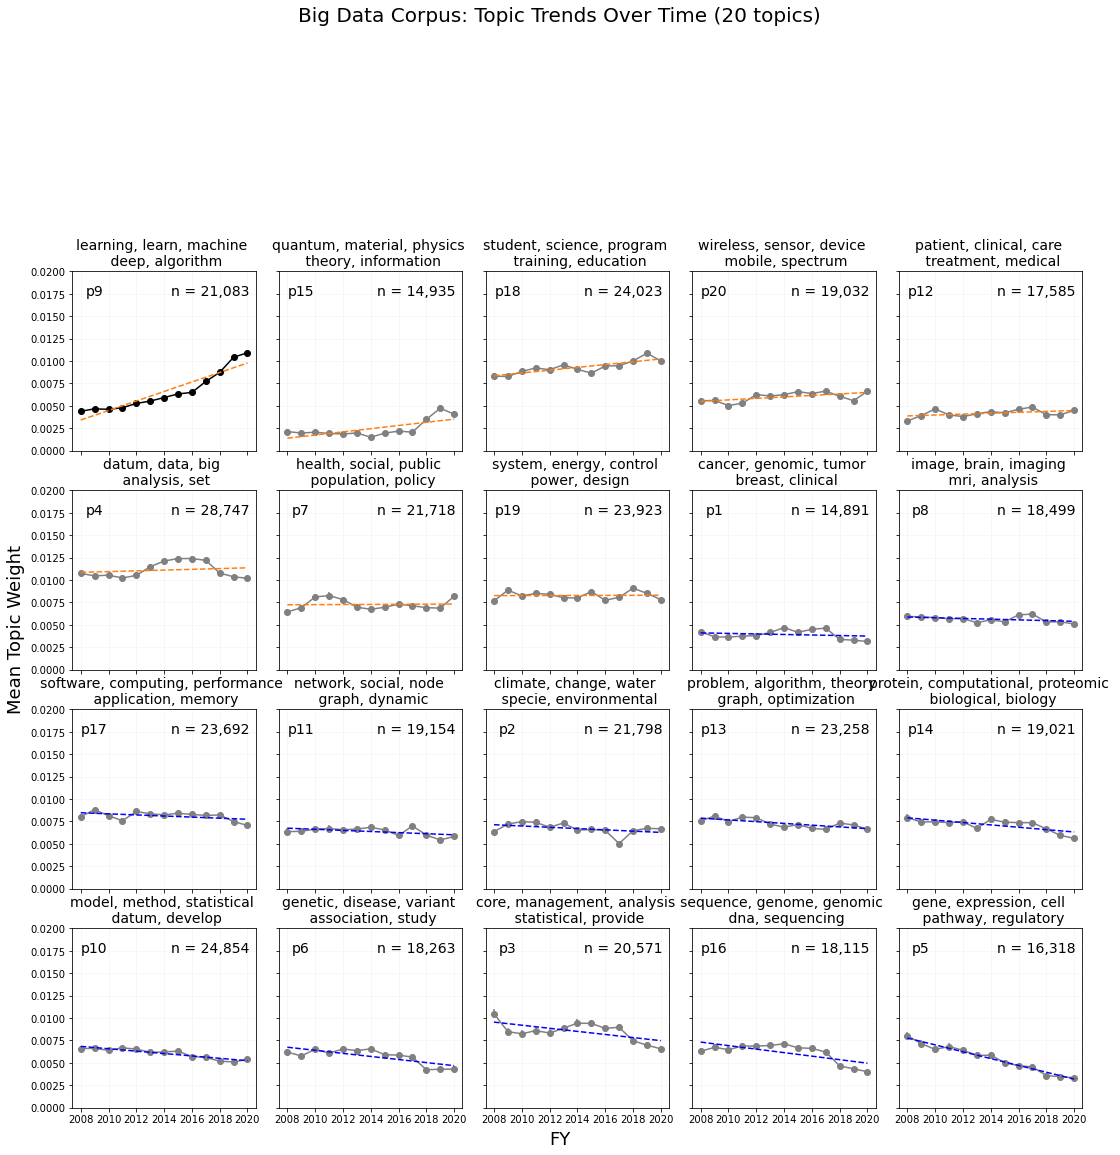

In [150]:
# set up grid
fig, ax = plt.subplots(4, 5, sharex = True, sharey = True, figsize=(15,16))
plt.ylim(bottom = 0.00, top = 0.02) 
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_filt.columns[col_idx+1]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt[col].values)
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.slope > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    if(count in [0]): # upward trend in 2020, 20: [0,1,4,9,12]
        line_color = 'black'
    else: # downward trend in 2020
        line_color = 'gray'
    
    ax[i,j].errorbar(topic_wts_filt["FY"], topic_wts_filt[col], 
            yerr = np.array(topic_wts_se_filt[col]), fmt = '-o', color = line_color, zorder = 10) 
    
    ax[i,j].plot(topic_wts_filt["FY"], \
        (topic_wts_filt["FY"]*linear_fit.slope)+linear_fit.intercept, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # add annotations - number of nonzero project topic weights per point
    #for k, txt in enumerate(topic_counts_filt[col]):
    #    ax[i,j].annotate(txt, xy = (topic_wts_2010_2019["START_YEAR"][k+25], topic_wts_2010_2019[col][k+25]), \
    #                    xycoords = 'data', xytext = (1,8), textcoords = "offset points")

    # put legend on two lines for topics 17, 21
    #if count == 16:
    #    ax[i,j].set_title('interagency_agreement_niaid, \n avian_influenza, basic, swine, pathogenic', \
    #                      fontsize = 12)
    #elif count == 27:
    #    ax[i,j].set_title('poultry, transmission, \n avian_influenza_virus, raptor, bird', fontsize = 12)
    #else:
    ax[i,j].set_title(new_leg[col_idx], fontsize = 14)
    
    # add topic number to each plot
    ax[i,j].text(0.12, 0.89, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.75, 0.89, "n = " + f"{n_by_topic[col_idx]:,}", horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Big Data Corpus: Topic Trends Over Time (20 topics)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.75)

plt.savefig("Big_data_trends_20.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("./figures/pan_05topic_trends.pdf", dpi = 800, bbox_inches = "tight")
plt.show()

#### Dominant Topic Funding Calculation

In [ ]:
doc_topic[0:10,:]

In [ ]:
type(doc_topic)

In [ ]:
dom_top_df = df.copy()

In [ ]:
dom_top_df['dom_top'] = np.argmax(doc_topic, axis=1)

In [ ]:
dom_top_df['dom_top'][0:20]

In [ ]:
dom_top_df.head()

In [ ]:
dollars_by_top_yr = dom_top_df.groupby(['dom_top', 'FY']).agg(COST = ('FY_TOTAL_COST_SUM', 'sum'),
                                        NUM_PROJECTS = ('PROJECT_ID', 'count'))
dollars_by_top_yr

In [ ]:
dollars_by_top_yr.index.get_level_values(0)

In [ ]:
dollars_by_top_yr.loc[0,'2008']

In [61]:
year = dollars_by_top_yr.loc[0]['COST'].index.values.astype('int')
year

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020])

In [77]:
dollars_by_top_yr.loc[1]['COST'].values

array([2.49584900e+07, 4.84257350e+07, 4.43161280e+07, 8.42726020e+07,
       2.70007410e+07, 1.94718570e+07, 1.44426010e+07, 2.19935570e+07,
       2.18596360e+07, 2.25130660e+07, 2.91272290e+07, 2.87742200e+07,
       1.71029352e+09])

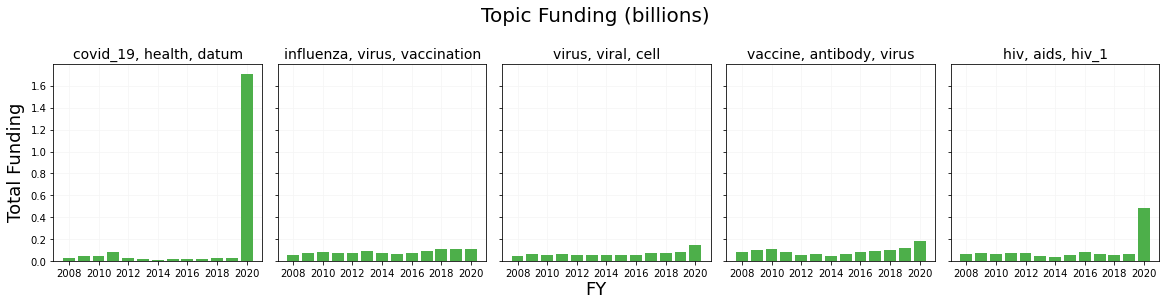

In [88]:
# set up grid
fig, ax = plt.subplots(1, 5, sharex = True, sharey = True, figsize=(16,4))
#plt.ylim(bottom = 0, top = 200) 
#plt.yscale('log')
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count, topic in enumerate([1,2,0,3,4]):
        
    # map count to i,j in grid
    #i = count // 5
    j = count % 5
    
    year = dollars_by_top_yr.loc[topic]['COST'].index.values.astype('int')
    cost = dollars_by_top_yr.loc[topic]['COST'].values/1000000000
    
    ax[j].bar(year, cost, color = cb_pal['green']) 
    ax[j].grid(color = "whitesmoke")   
    ax[j].set_title(new_leg[topic], fontsize = 14)
    ax[j].set_axisbelow(True)
    
    # add topic number to each plot
    #ax[j].text(0.10, 0.85, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    #ax[j].text(0.75, 0.85, "n = " + str(n_by_topic[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    
fig.suptitle('Topic Funding (billions)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Total Funding', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.78)

#plt.savefig("./figures/pan_05topic_trends_alt.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("./figures/pan_05topic_trends_alt.pdf", dpi = 800, bbox_inches = "tight")
plt.show()

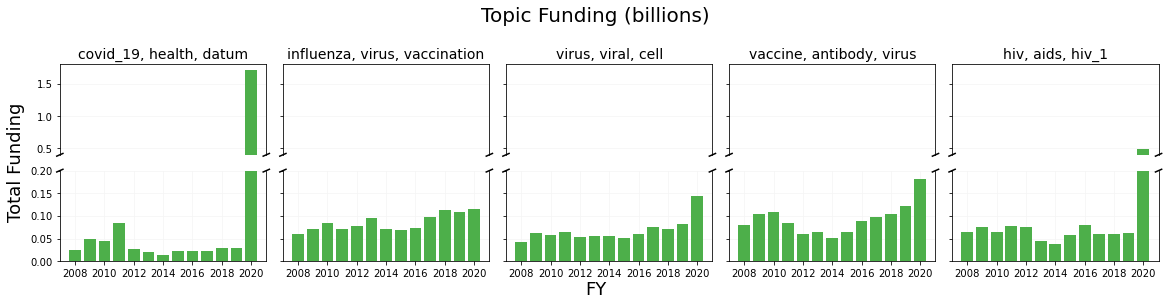

In [112]:
# set up grid
fig, ax = plt.subplots(2, 5, sharex = False, sharey = 'row', figsize=(16,4))
#plt.ylim(bottom = 0, top = 200) 
#plt.yscale('log')
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count, topic in enumerate([1,2,0,3,4]):
        
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    # plot data
    year = dollars_by_top_yr.loc[topic]['COST'].index.values.astype('int')
    cost = dollars_by_top_yr.loc[topic]['COST'].values/1000000000
    
    ax[i+1,j].bar(year, cost, color = cb_pal['green']) 
    ax[i+1,j].grid(color = "whitesmoke")   
    ax[i+1,j].set_axisbelow(True)
    
    ax[i,j].bar(year, cost, color = cb_pal['green']) 
    ax[i,j].grid(color = "whitesmoke")   
    ax[i,j].set_title(new_leg[topic], fontsize = 14)
    ax[i,j].set_axisbelow(True)
    
    # broken axis
    ax[i,j].spines['bottom'].set_visible(False)
    ax[i,j].set_xticks([])
    ax[i+1,j].set_xticks(np.arange(2008,2021,2))
    ax[i+1,j].spines['top'].set_visible(False)
    ax[i+1,j].set_ylim([0,0.2])
    ax[i,j].set_ylim([0.4,1.8])
    
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax[i,j].transAxes, color='k', clip_on=False)
    ax[i,j].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax[i,j].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax[i+1,j].transAxes)  # switch to the bottom axes
    ax[i+1,j].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax[i+1,j].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    
    # add topic number to each plot
    #ax[j].text(0.10, 0.85, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    #ax[j].text(0.75, 0.85, "n = " + str(n_by_topic[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    
fig.suptitle('Topic Funding (billions)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Total Funding', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.78)

plt.savefig("./figures/OECD/pan_05topic_funding.png", dpi = 800, bbox_inches = "tight")
plt.savefig("./figures/OECD/pan_05topic_funding.pdf", dpi = 800, bbox_inches = "tight")
plt.show()